In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torch.utils.data import random_split

In [ ]:
batch_size=64
hidden_dim_res=32
num_residual_layers=2
num_hiddens=128
num_embeddings= 512
embedding_dim=64
commitment_cost=0.25
learning_rate=1e-3
updates = 5000

In [ ]:
df= pd.read_csv('/content/drive/chaitanya/MyDrive/Butterfly_dataset/Train.csv')
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


(128, 128, 3)

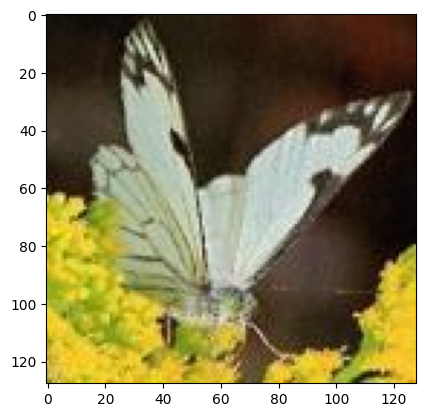

In [ ]:
im= plt.imread("/content/drive/chaitanya/MyDrive/Butterfly_resized/Train_images/Image_1.jpg")
plt.imshow(im)
im.shape

In [ ]:
csv_path = '/content/drive/chaitanya/MyDrive/Butterfly_resized/train_labels.csv'
image_direct = '/content/drive/chaitanya/MyDrive/Butterfly_resized/Train_images'

In [ ]:

'''creates a customized dataset that Loads the csv files with Images paths and Labels and images,
apply transformations to images'''

class ButterflyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None,label_to_num_index=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_num_index = label_to_num_index

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.annotations.iloc[idx, 1]
        label = self.label_to_num_index[label] if self.label_to_num_index else int(label)

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
'''applying transformations and creating a unique labels,map those to numerical indices'''

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


labels = pd.read_csv('/content/drive/chaitanya/MyDrive/Butterfly_resized/train_labels.csv').iloc[:, 1]
unique_labels = list(set(labels))#unique set of labels

label_to_num_index = {label: idx for idx, label in enumerate(unique_labels)}


dataset = ButterflyDataset(csv_file='/content/drive/chaitanya/MyDrive/Butterfly_resized/train_labels.csv',
                           root_dir='/content/drive/chaitanya/MyDrive/Butterfly_resized/Train_images',
                           transform=transform,
                           label_to_num_index=label_to_num_index)


In [ ]:
'''Spliting the dataset into training and validation sets,80% - training and 20%-validation'''


train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1])

torch.Size([3, 128, 128])
13


In [ ]:
for i in range(len(val_dataset)):
    img, label = dataset[i]
    print(f"Image {i} with shape: {img.shape}, corresponding Label: {label}")
    if i == 10:
        break

Image 0 with shape: torch.Size([3, 128, 128]), corresponding Label: 46
Image 1 with shape: torch.Size([3, 128, 128]), corresponding Label: 30
Image 2 with shape: torch.Size([3, 128, 128]), corresponding Label: 62
Image 3 with shape: torch.Size([3, 128, 128]), corresponding Label: 56
Image 4 with shape: torch.Size([3, 128, 128]), corresponding Label: 17
Image 5 with shape: torch.Size([3, 128, 128]), corresponding Label: 44
Image 6 with shape: torch.Size([3, 128, 128]), corresponding Label: 17
Image 7 with shape: torch.Size([3, 128, 128]), corresponding Label: 22
Image 8 with shape: torch.Size([3, 128, 128]), corresponding Label: 62
Image 9 with shape: torch.Size([3, 128, 128]), corresponding Label: 47
Image 10 with shape: torch.Size([3, 128, 128]), corresponding Label: 4


In [ ]:
# for images, labels in train_loader:
#     print(f"Batch of images has shape: {images.shape}")
#     print(f"Batch of labels: {labels}")
#     break
# unique_labels = list(set(labels))
# label_to_num_index = {label: idx for idx, label in enumerate(unique_labels)}


# labels_encoded = [label_to_num_index[label] for label in labels]
# print(labels_encoded)

Batch of images has shape: torch.Size([32, 3, 128, 128])
Batch of labels: ('MOURNING CLOAK', 'MOURNING CLOAK', 'RED ADMIRAL', 'GREY HAIRSTREAK', 'ORCHARD SWALLOW', 'CLOUDED SULPHUR', 'RED CRACKER', 'GREAT EGGFLY', 'AN 88', 'ULYSES', 'ZEBRA LONG WING', 'LARGE MARBLE', 'CLEOPATRA', 'INDRA SWALLOW', 'MANGROVE SKIPPER', 'INDRA SWALLOW', 'RED POSTMAN', 'GREAT EGGFLY', 'SCARCE SWALLOW', 'MOURNING CLOAK', 'PURPLE HAIRSTREAK', 'TWO BARRED FLASHER', 'APPOLLO', 'COMMON BANDED AWL', 'CRIMSON PATCH', 'APPOLLO', 'SILVER SPOT SKIPPER', 'DANAID EGGFLY', 'INDRA SWALLOW', 'BANDED PEACOCK', 'RED SPOTTED PURPLE', 'BROWN SIPROETA')
[9, 9, 15, 20, 22, 17, 21, 18, 11, 6, 3, 23, 1, 14, 0, 14, 5, 18, 8, 9, 12, 25, 24, 7, 4, 24, 10, 19, 14, 16, 2, 13]


With Residual Network

In [ ]:
'''Residual Stack- a stack of res layers which will be used in encode and decoder networks
encoder- to captures more refined features and enhances feature representations
decoder- Improves upsampled features'''


class ResidualStack(nn.Module):
    def __init__(self, in_channels, hidden_dim, hidden_dim_res, num_residual_layers):
        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=in_channels,
                          out_channels=hidden_dim_res,
                          kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=hidden_dim_res,
                          out_channels=hidden_dim,
                          kernel_size=1, stride=1, bias=False)
            ) for _ in range(self.num_residual_layers) #Repeating n no.of layers
        ])

    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = x + self.layers[i](x)
        return F.relu(x)



Encoder

In [ ]:
'''Takes input as image and compresses the image to a latent represntation
   this input passed through series of conv and activation function
   layers for downsampling.
   Gives encoded latent vectors for further quantization'''

class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, hidden_dim_res, num_residual_layers):
        super(Encoder, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_dim//2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=hidden_dim//2, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True)
        )


        self.residual_stack =ResidualStack(in_channels=hidden_dim,hidden_dim=hidden_dim,num_residual_layers=num_residual_layers,
                                      hidden_dim_res=hidden_dim_res)

    def forward(self, inputs):
        x = self.encoder(inputs)
        return self.residual_stack(x)


Decoder

In [ ]:
'''The downsampling from the encoder needs to be upsampled by this decoder architecture
   by takes input as latent vector from encoder and this input passed through series of transpose conv and activation function
   layers for upsampling and finally gives the reconstructed images'''

class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, hidden_dim_res, num_residual_layers,out_channels=3):
        super(Decoder, self).__init__()
        # self.out_channels=out_channels



        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1),
            ResidualStack(in_channels=hidden_dim,hidden_dim=hidden_dim,num_residual_layers=num_residual_layers,
                                      hidden_dim_res=hidden_dim_res),
            # nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=hidden_dim, out_channels=hidden_dim//2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=hidden_dim//2, out_channels=self.out_channels, kernel_size=4, stride=2, padding=1)

        )

    def forward(self, inputs):

        x = self.decoder(x)
        return x


Vector Quantization

Discrete latent representation of VQVAE

Channel dimension will be used as the space in which to quantize remaining other dims are flattened

In [ ]:
class VQ(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VQ, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Embedding layer to map input to embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)


    def forward(self,inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()#reshape inputs to batch, height, width, channel
        # print("inputs.shape")
        flat_input = inputs.view(-1, self.embedding_dim)
        # print("flat_input.shape")
        distances=(torch.sum(flat_input**2,dim=1,keepdim=True)
                  +torch.sum(self.embedding.weight**2,dim=1)
                  -2*torch.matmul(flat_input,self.embedding.weight.t())) #distances from inputs to embeddings

        encoding_indices=torch.argmin(distances, dim=1).unsqueeze(1) #closest embedding
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)

        z_quantized = torch.matmul(encodings, self.embedding.weight).view(inputs.shape)
        # print("z_quantized.shape")
        loss = F.mse_loss(z_quantized, inputs.detach()) + self.commitment_cost * F.mse_loss(z_quantized.detach(), inputs)

        z_quantized = inputs + (z_quantized - inputs).detach()#perserving the grads(pass the gradients from the decoder to the encoder unaltered.)

        z_quantized = z_quantized.permute(0, 3, 1, 2).contiguous()#reshape to original input shape

        return loss,z_quantized,encodings





VQVAE Model

In [ ]:
class VQVAE(nn.Module):
  def __init__(self,hidden_dim, hidden_dim_res, num_residual_layers, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()

        self.encoder =Encoder(in_channels=3, hidden_dim=hidden_dim,hidden_dim_res=hidden_dim_res ,num_residual_layers=num_residual_layers,)
        self.pre_vq_conv = nn.Conv2d(in_channels=hidden_dim,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        self.vec_quan = VQ(num_embeddings, embedding_dim, commitment_cost)
        # self.pre_decoder_conv = nn.Conv2d(in_channels=embedding_dim,
                                          # out_channels=hidden_dim,
                                          # kernel_size=3,
                                          # stride=1,
                                          # padding=1)
        self.decoder = Decoder(in_channels=embedding_dim, hidden_dim=hidden_dim,hidden_dim_res, num_residual_layers)

  def forward(self, x):

    z_e = self.encoder(x)

    z_e = self.pre_vq_conv(z_e)
    # print("z_e.shape")

    z_quantized, embdd_loss = self.vec_quan(z_e)
    # print("z_quantized.shape")

    x_reconstruction = self.decoder(z_quantized)
    # print("x_reconstruction.shape")

    return embdd_loss, x_reconstruction, z_quantized


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
batch_size=64
hidden_dim_res=32
num_residual_layers=2
num_hiddens=128
num_embeddings= 512
embedding_dim=64
commitment_cost=0.25
learning_rate=1e-3

updates = 5000

In [ ]:
model = VQVAE(num_hiddens,hidden_dim_res,num_residual_layers,num_embeddings, embedding_dim, commitment_cost).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model.train()
train_recon_error = []


for i in range(updates):
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    embdd_loss, x_reconstruction,_= model(data)
    recon_error = F.mse_loss(x_reconstruction, data)
    loss = recon_error + embdd_loss
    loss.backward()

    optimizer.step()

    train_recon_error.append(recon_error.item())

    if i % 100 == 0:
        mean_recon_error = np.mean(train_recon_error)
        steps = len(train_loader)
        print('%d iterations' % (i+1))
        print(f'Average_reconstruction_error: %.3f {mean_recon_error/steps}')
        print()

100 iterations
Average_reconstruction_error: 1.158

200 iterations
Average_reconstruction_error: 0.803

300 iterations
Average_reconstruction_error: 0.793

400 iterations
Average_reconstruction_error: 0.637

500 iterations
Average_reconstruction_error: 0.490

600 iterations
Average_reconstruction_error: 0.483

700 iterations
Average_reconstruction_error: 0.471

800 iterations
Average_reconstruction_error: 0.406

900 iterations
Average_reconstruction_error: 0.374

1000 iterations
Average_reconstruction_error: 0.340

1100 iterations
Average_reconstruction_error: 0.303

1200 iterations
Average_reconstruction_error: 0.277

1300 iterations
Average_reconstruction_error: 0.258

1400 iterations
Average_reconstruction_error: 0.242

1500 iterations
Average_reconstruction_error: 0.232

1600 iterations
Average_reconstruction_error: 0.223

1700 iterations
Average_reconstruction_error: 0.234

1800 iterations
Average_reconstruction_error: 0.222

1900 iterations
Average_reconstruction_error: 0.211

20

In [ ]:
# Finding reconstruction_error on Validation Loop by keeping model on eval mode
val_recon_error = []

model.eval()
with torch.no_grad():
    for val_data, _ in val_loader:
        val_data = val_data.to(device)
        _, val_reconstruction, _ = model(val_data)
        val_recon_error = F.mse_loss(val_reconstruction, val_data)
        val_res_recon_error.append(val_recon_error.item())

    avg_val_recon_error = np.mean(val_res_recon_error)
    print(f'Validation_reconstruction_error: {avg_val_recon_error:.3f}')


Validation_reconstruction_error: 0.063


Visualizing the original and reconstructed images

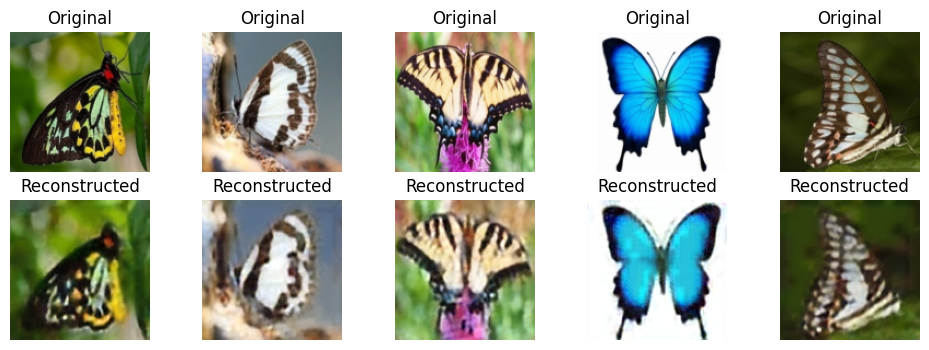

In [ ]:

original = val_data.cpu().detach().numpy()
reconstructed = val_reconstruction.cpu().detach().numpy()


num_images = 5
plt.figure(figsize=(12, 4))
for i in range(num_images):
    #original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(original[i].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    #reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed[i].transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()



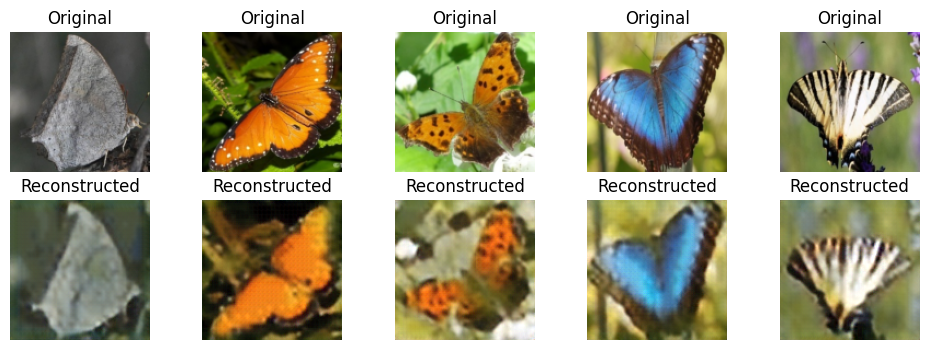

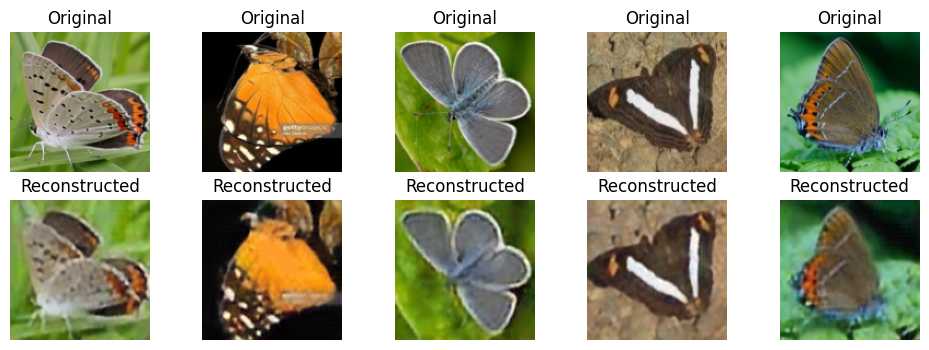

In [ ]:

original = data.cpu().detach().numpy()
reconstructed = x_reconstruction.cpu().detach().numpy()


num_images = 5
plt.figure(figsize=(12, 4))
for i in range(num_images):
    #original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(original[i].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    #reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed[i].transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()



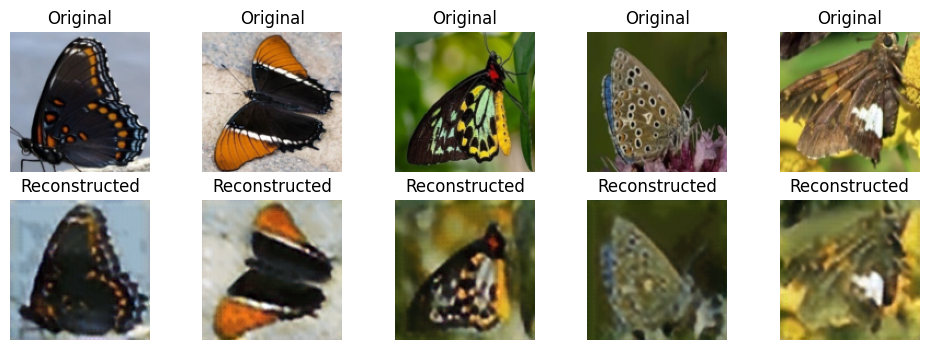

Without Residual Network

Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_layer_dim):
        super(Encoder, self).__init__()

        self.encoder_layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_layer_dim // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_layer_dim // 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=hidden_layer_dim // 2, out_channels=hidden_layer_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_layer_dim),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=hidden_layer_dim, out_channels=hidden_layer_dim, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.encoder_layers(x)

Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_layer_dim, output_channels=3):
        super(Decoder, self).__init__()

        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=hidden_layer_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_layer_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=hidden_layer_dim, out_channels=hidden_layer_dim//2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_layer_dim//2),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=hidden_layer_dim//2, out_channels=output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder_layers(x)

Original and Reconstructed images without Res Layers
Blurry images compared to with Res Layers

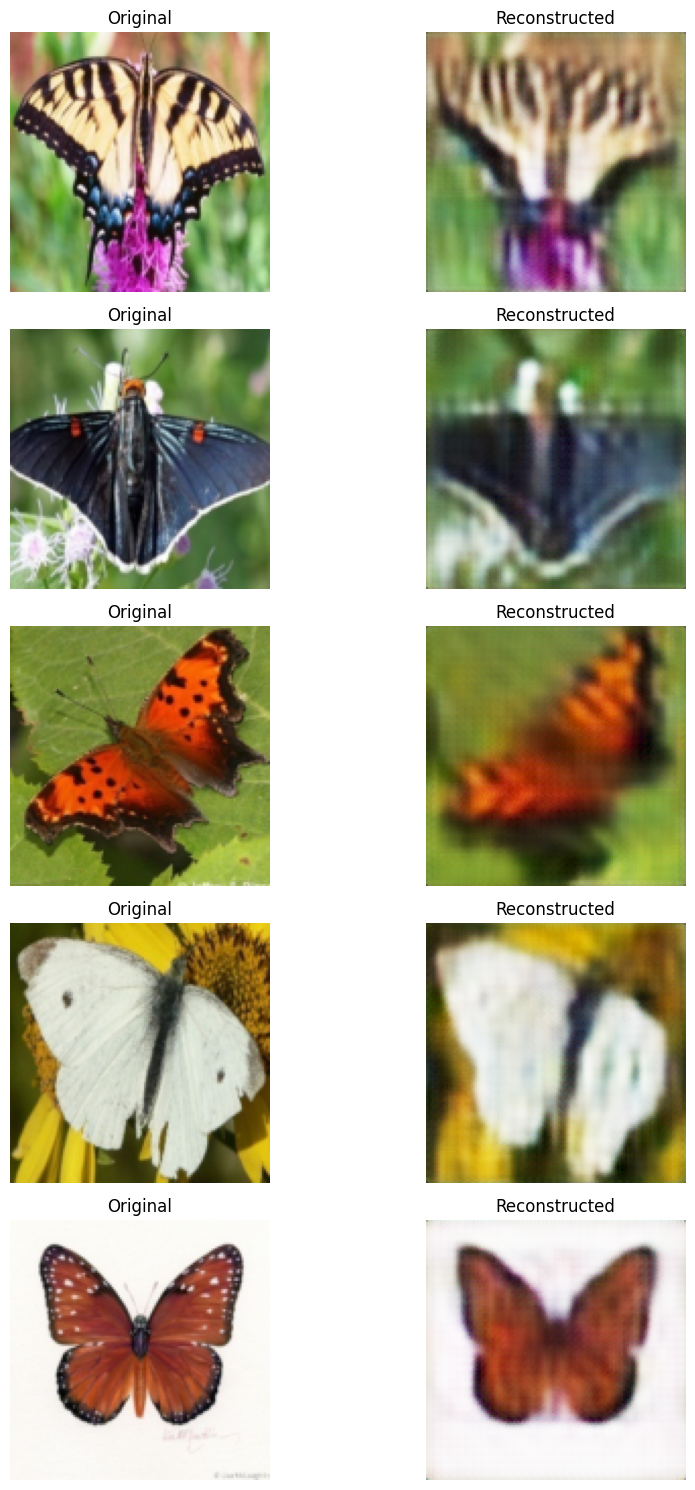

Extracting latent vectors from encoder to use as features for classifier

In [ ]:

model.eval()
train_latent_vectors = []
train_labels = []

with torch.no_grad():
    for data, label in dataloader:
        data = data.to(device)
        z_e = model.encoder(data)
        z_e = model.pre_vq_conv(z_e)
        _,_, z_q = model.vec_quan(z_e)

        train_latent_vectors.append(z_q.view(z_q.size(0), -1).cpu().numpy())  # Flatten the latent vectors
        train_labels.extend(label.numpy())

train_latent_vectors = np.concatenate(train_latent_vectors, axis=0)
train_labels = np.array(train_labels)

return train_latent_vectors, train_labels

print(train_latent_vectors)
print(train_labels)

[[-0.22779398 -0.36553416 -0.23323958 ...  0.9083062   0.9726469
   1.1799924 ]
 [-0.05613895 -0.00473533 -0.05613895 ...  0.18611546  0.01829348
   0.10897065]
 [-0.02728012 -0.23390259 -0.21505821 ...  0.30616462  0.31629202
   0.33325043]
 ...
 [-0.05613895 -0.11851627 -0.1325536  ...  0.21454492 -0.08466874
   0.17831999]
 [-0.130137   -0.18878102 -0.18878102 ...  0.6083321   0.6083321
   0.71090186]
 [-0.21128395 -0.3157345  -0.28485173 ...  0.9726469   0.8385542
   1.1799924 ]]
[70 43 50 46 24 57 23 26 62  9  5 52 30 16 23  4 34  5 39 18 11 19 72 39
 19 37 14  1 48  4 73  6 34 38 20 47 50 17  3 54 28 49 60 25 25 16 48  4
 46  4 67 18 65  3  8 36 14 47 44 32 15 69 61 71  4  8  1 42 55 54 29 46
 28  7 45 10 44 72 42 66  1  2  8 70  8  2 50 32 13 63  6  6 22  2 33 58
 66 74 23 74 14 66 43 20 14 36  8 64 18 28  5 13 64 13 53 11 19 74 15  2
 56  4 15  3 22 43 65 16  4 66 47 12 14 19 57 43 64 72 20 32 61 70 66 71
 59 62 56 45 30  6 35 69 58 15 55 66 35 55 13 74 56 68 55  5 30  8  2 37


In [ ]:

# model.eval()
# val_latent_vectors = []
# val_labels = []

# with torch.no_grad():
#     for data, label in dataloader:
#         data = data.to(device)
#         z_e = model.encoder(data)
#         z_e = model.pre_vq_conv(z_e)
#         _,_, z_q = model.vec_quan(z_e)

#         val_latent_vectors.append(z_q.view(z_q.size(0), -1).cpu().numpy())  # Flatten the latent vectors
#         val_labels.extend(label.numpy())

# val_latent_vectors = np.concatenate(val_latent_vectors, axis=0)
# val_labels = np.array(val_labels)

# return val_latent_vectors, val_labels

# # print(val_latent_vectors)
# # print(val_labels)

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)#takes single-channel inputs

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, 256, 256)
        return self.resnet(x)

In [ ]:
num_classes = len(label_to_num_index)
MODEL = ResNet50(num_classes=num_classes).to(device)

In [ ]:
optimizer1 = optim.Adam(MODEL.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()#multiclass

In [ ]:
num_epochs = 100
train_data = train_latent_vectors.clone().detach().to(device).float()
train_labels = train_labels.clone().detach().to(device).long()

MODEL.train()

for epoch in range(num_epochs):
    optimizer1.zero_grad()
    outputs = MODEL(train_data)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer1.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation on validation
MODEL.eval()
val_data = val_latent_vectors.clone().detach().to(device).float()
val_labels = val_labels.clone().detach().to(device).long()

with torch.no_grad():
    val_outputs = MODEL(val_data)
    _, predicted = torch.max(val_outputs, 1)
    accuracy = accuracy_score(val_labels.cpu(), predicted.cpu())

print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Epoch [1/100], Loss: 4.3176
Epoch [2/100], Loss: 10.0474
Epoch [3/100], Loss: 7.7329
Epoch [4/100], Loss: 8.3388
Epoch [5/100], Loss: 6.3181
Epoch [6/100], Loss: 5.2099
Epoch [7/100], Loss: 3.4646
Epoch [8/100], Loss: 2.8499
Epoch [9/100], Loss: 2.2257
Epoch [10/100], Loss: 1.5733
Epoch [11/100], Loss: 1.2086
Epoch [12/100], Loss: 1.0315
Epoch [13/100], Loss: 0.8935
Epoch [14/100], Loss: 0.7365
Epoch [15/100], Loss: 0.5895
Epoch [16/100], Loss: 0.4828
Epoch [17/100], Loss: 0.3823
Epoch [18/100], Loss: 0.2876
Epoch [19/100], Loss: 0.2102
Epoch [20/100], Loss: 0.1568
Epoch [21/100], Loss: 0.1208
Epoch [22/100], Loss: 0.0944
Epoch [23/100], Loss: 0.0752
Epoch [24/100], Loss: 0.0599
Epoch [25/100], Loss: 0.0458
Epoch [26/100], Loss: 0.0339
Epoch [27/100], Loss: 0.0257
Epoch [28/100], Loss: 0.0201
Epoch [29/100], Loss: 0.0161
Epoch [30/100], Loss: 0.0130
Epoch [31/100], Loss: 0.0105
Epoch [32/100], Loss: 0.0085
Epoch [33/100], Loss: 0.0070
Epoch [34/100], Loss: 0.0058
Epoch [35/100], Loss: 

Validation Accuracy: 57.69%

# GMM


GMM from scratch

In [ ]:
# class GMM:
#     def __init__(self, k, max_iter=10):
#         self.k = k
#         self.max_iter = max_iter

#     def initialize(self, X):
#         self.X=X
#         self.shape = X.shape
#         self.n, self.m = self.shape
#         self.phi = np.full(shape=self.k, fill_value=1/self.k)
#         self.weights = np.full(shape=self.shape, fill_value=1/self.k)

#         random_row = np.random.randint(low=0, high=self.n, size=self.k)
#         self.mu = [X[row_index,:] for row_index in random_row]
#         self.sigma = [np.cov(X.T) for _ in range(self.k)]
#         # random_clus=np.array_split(X,self.k)
#         # self.mu= [np.mean(x,axis=0) for x in random_clus]
#         # self.sigma=[np.cov(x.T) for x in random_clus]

#     def e_step(self, X):
#         self.weights = self.predict_proba(X)
#         self.phi = self.weights.mean(axis=0)

#     def m_step(self, X):
#         for i in range(self.k):
#             weight = self.weights[:, [i]]
#             total_weight = weight.sum()
#             self.mu[i] = (X * weight).sum(axis=0) / total_weight
#             self.sigma[i] = np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)

#     def fit(self, X):
#         self.initialize(X)
#         for iteration in range(self.max_iter):
#             self.e_step(X)
#             self.m_step(X)

#     def multivariate_normal(self, x, mu, cov):
#         size = x.shape[0]
#         det = np.linalg.det(cov)
#         norm_const = ((2 * np.pi)**-(len(x)/ 2)) * np.sqrt(det)
#         x_mu = x - mu
#         inv_cov = np.linalg.inv(cov)

#         result_exp = -0.5 * np.dot(x_mu.dot(inv_cov), x_mu.T)
#         result = np.exp(result_exp)
#         result=result.sum(axis=1)
#         if (result.shape[0]!=self.X.shape[0]):
#             result=np.zeros((self.X.shape[0],))
#         return norm_const * result

#     def multivariate_normal(self, x, mu, cov):

#         K = 10  # Number of components
#         D = x.shape[0]  # Dimensionality of the data
#         probability_density = 0

#         for k in range(K):
#             mu_k = mu[k]
#             sigma_k = cov[k]
#             det_sigma_k = np.linalg.det(sigma_k)
#             inv_sigma_k = np.linalg.inv(sigma_k)

#             normalization_factor = self.phi[k] / (np.power(2 * np.pi, D / 2) * np.sqrt(det_sigma_k))
#             exponent_term = -0.5 * np.dot(np.dot((x - mu_k).T, inv_sigma_k), (x - mu_k))

#             probability_density += normalization_factor * np.exp(exponent_term)
#         print(probability_density)
#         return probability_density

#     def predict_proba(self, X):
#         likelihood = np.zeros((self.n, self.k))
#         for i in range(self.k):
#             likelihood[:,i] = self.multivariate_normal(X, self.mu[i], self.sigma[i])
#         numerator = likelihood * self.phi
#         denominator = numerator.sum(axis=1)[:, np.newaxis]
#         return self.weights


#     def predict(self, X):
#         self.weights = self.predict_proba(X)
#         return np.argmax(self.weights, axis=1)

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [ ]:
n_components = 64
gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42)
gmm.fit(train_latent_vectors)

GaussianMixture(covariance_type='diag', n_components=64, random_state=42)

In [ ]:
n_components = 100
gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42)
gmm.fit(train_latent_vectors)

GaussianMixture(covariance_type='diag', n_components=100, random_state=42)

In [ ]:
num_samples = 100
sampled_latents = gmm.sample(num_samples)[0]
sampled_latents = torch.tensor(sampled_latents, dtype=torch.float32).to(device)

In [ ]:
with torch.no_grad():
    sampled_latents = sampled_latents.view(-1, 64, 16, 16)
    generated_images = model.decoder(sampled_latents).cpu()

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
print("Its for n_components=64")
for i, ax in enumerate(axes.flat):
    img = generated_images[i].permute(1, 2, 0).numpy()
    ax.imshow((img * 255).astype(np.uint8))  # Scaling [0, 255] range
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
print("Its for n_components=100")
for i, ax in enumerate(axes.flat):
    img = generated_images[i].permute(1, 2, 0).numpy()
    ax.imshow((img * 255).astype(np.uint8))  # Scaling [0, 255] range
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.